In [ ]:
# !pip install numpy
# !pip install pillow
# !pip install tensorflow
# !pip install keras
# !pip install opencv-python
# !pip install matplotlib
# !pip install seaborn

# # using dataset https://www.kaggle.com/datasets/stoicstatic/face-recognition-dataset

In [1]:

import random
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.applications.mobilenet  import MobileNet
from keras.applications.mobilenet  import preprocess_input


random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)


In [3]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0']


In [ ]:
FOLDER_FACE_PATH = './CelebDataProcessed'

def readImage(index):
    path = os.path.join(FOLDER_FACE_PATH, index[0], index[1])
    img = cv2.imread(path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def splitDataset(ratio=0.8):
    train = {}
    test = {}
    folders = os.listdir(FOLDER_FACE_PATH)
    folderTrainSize = int(len(folders) * ratio)
    random.shuffle(folders)

    trainFolders = folders[:folderTrainSize]
    testFolders = folders[folderTrainSize:]
    for folder in trainFolders:
        files = os.listdir(os.path.join(FOLDER_FACE_PATH, folder))
        train[folder] = files

    for folder in testFolders:
        files = os.listdir(os.path.join(FOLDER_FACE_PATH, folder))
        test[folder] = files
            
    return train, test
train, test = splitDataset(0.9)


28592 triplets created
3398 total triplets created
(('1490', '20.jpg'), ('1490', '5.jpg'), ('840', '1.jpg'))


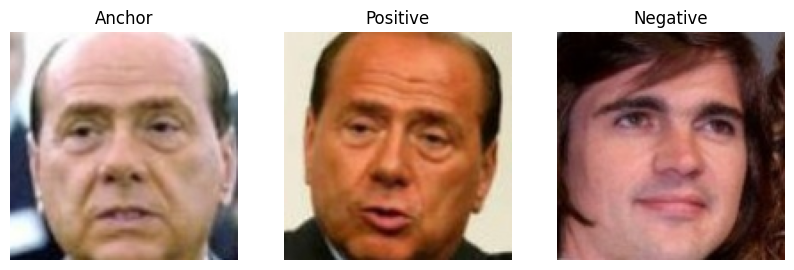

(('1584', '0.jpg'), ('1584', '5.jpg'), ('339', '0.jpg'))


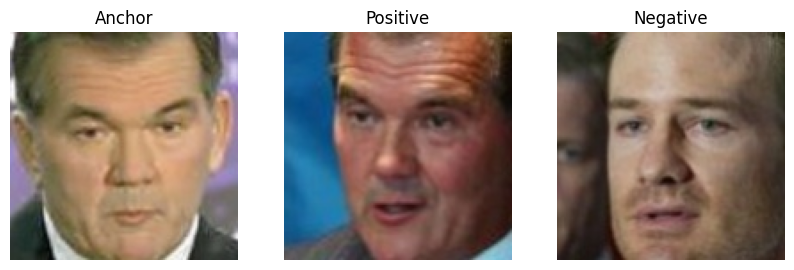

(('720', '0.jpg'), ('720', '1.jpg'), ('1241', '1.jpg'))


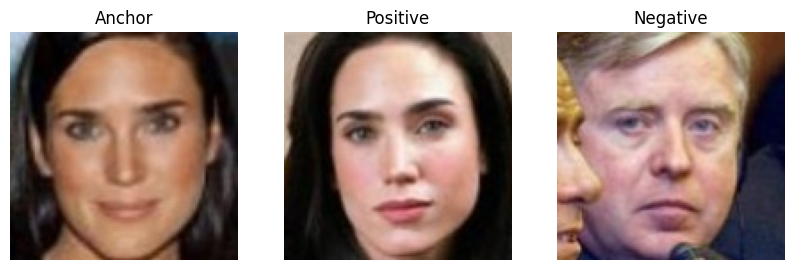

In [5]:

def createTriplet(train):
    # anchor and positive are from same class, negative is from different class
    triplets = []
    folders = list(train.keys())

    for folder in folders:
        files = train[folder]
        if len(files) < 2:
            continue
        anchorPositivePairs = []
        for i in range(len(files)):
            for j in range(i + 1, len(files)):
                anchorPositivePairs.append((files[i], files[j]))

        for anchor, positive in anchorPositivePairs:
            negativeFolder = folder
            while negativeFolder == folder:
                negativeFolder = random.choice(folders)
            negativeFiles = train[negativeFolder]
            negative = random.choice(negativeFiles)
            triplets.append(((folder, anchor), (folder, positive), (negativeFolder, negative)))
            
    random.shuffle(triplets)
    return triplets

tripletsTrain = createTriplet(train)
tripletsTest = createTriplet(test)
print (len(tripletsTrain), 'triplets created')
print (len(tripletsTest), 'total triplets created')

# Show image triplet
for i in range(3):
    print(tripletsTrain[i])
    anchor = readImage(tripletsTrain[i][0])
    positive = readImage(tripletsTrain[i][1])
    negative = readImage(tripletsTrain[i][2])

    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(anchor)
    plt.title('Anchor')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(positive)
    plt.title('Positive')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(negative)
    plt.title('Negative')
    plt.axis('off')

    plt.show()




In [6]:
def batchGenerator(triplets, batchSize=32):
    while True:
        anchorBatch = []
        positiveBatch = []
        negativeBatch = []
        for i in range(batchSize):
            triplet = random.choice(triplets)
            anchor = readImage(triplet[0])
            positive = readImage(triplet[1])
            negative = readImage(triplet[2])

            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

            anchorBatch.append(anchor)
            positiveBatch.append(positive)
            negativeBatch.append(negative)

        anchorBatch = tf.convert_to_tensor(np.array(anchorBatch, dtype="float32"))
        positiveBatch = tf.convert_to_tensor(np.array(positiveBatch, dtype="float32"))
        negativeBatch = tf.convert_to_tensor(np.array(negativeBatch, dtype="float32"))
        labels = tf.zeros((batchSize, 1), dtype=tf.float32)

        yield (anchorBatch, positiveBatch, negativeBatch), labels





In [7]:
def getEmbeddingModel(inputShape):
    baseModel = MobileNet(input_shape=inputShape, include_top=False, weights='imagenet', pooling='avg')
    for layer in baseModel.layers:
        layer.trainable = False

    model = tf.keras.Sequential([
        baseModel,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name='Embedding')
    return model

In [8]:
#  Create siamese network model with triplet loss

# Distance layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
class DistanceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def getSiameseModel(inputShape=(128, 128, 3)):
    embeddingModel = getEmbeddingModel(inputShape)

    anchorInput = tf.keras.layers.Input(name='anchor', shape=inputShape)
    positiveInput = tf.keras.layers.Input(name='positive', shape=inputShape)
    negativeInput = tf.keras.layers.Input(name='negative', shape=inputShape)

    anchorEmbedding = embeddingModel(anchorInput)
    positiveEmbedding = embeddingModel(positiveInput)
    negativeEmbedding = embeddingModel(negativeInput)

    # Distance layer
    distances = DistanceLayer()(anchorEmbedding, positiveEmbedding, negativeEmbedding)

    model = tf.keras.Model(inputs=[anchorInput, positiveInput, negativeInput], outputs=distances, name='SiameseNetwork')
    return model

SiameseModel  = getSiameseModel()
SiameseModel.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, 256)       │  3,887,040 │ anchor[0][0],     │
│ (Sequential)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance_layer      │ [(None), (None)]  │          0 │ Embedding[0][0],  │
│ (DistanceLayer)     │                   │            │ Embedding[1][0],  │
│                     │                   │            │ Embedding[2][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,887,040 (14.83 MB)

 Trainable params: 657,152 (2.51 MB)

 Non-trainable params: 3,229,888 (12.32 MB)

In [9]:
# Custom training step with triplet loss
class SiameseModelClass(tf.keras.Model):
    def __init__(self, siameseModel, margin=0.5):
        super(SiameseModelClass, self).__init__()
        self.siameseModel = siameseModel
        self.margin = margin
        self.lossTracker = tf.keras.metrics.Mean(name='loss')

    def call(self, inputs):
        return self.siameseModel(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            ap_distance, an_distance = self.siameseModel(data[0], training=True)
            loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
            loss = tf.reduce_mean(loss)

        gradients = tape.gradient(loss, self.siameseModel.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siameseModel.trainable_weights))
        self.lossTracker.update_state(loss)
        return {'loss': self.lossTracker.result()}

    def test_step(self, data):
        ap_distance, an_distance = self.siameseModel(data[0], training=False)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        loss = tf.reduce_mean(loss)
        self.lossTracker.update_state(loss)
        return {'loss': self.lossTracker.result()}

    @property
    def metrics(self):
        return [self.lossTracker]
    




In [ ]:
siameseModel = SiameseModelClass(SiameseModel)
siameseModel.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

# early stopping callback
cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              verbose=1, 
                              mode='min', 
                              min_lr=0.00001)

cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/siameseModel_celeb.keras',
    monitor= 'val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

history = siameseModel.fit(batchGenerator(tripletsTrain, batchSize=128),
          steps_per_epoch=100,
          validation_data=batchGenerator(tripletsTest, batchSize=128),
          callbacks=[cb_early_stopping, cb_model_checkpoint,reduce_lr],
          validation_steps=100,
          epochs=128)


Epoch 1/128
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0357
Epoch 1: val_loss improved from None to 0.18768, saving model to checkpoints/siameseModel.keras


c:\Users\admin\miniconda3\envs\pyenv310\lib\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


100/100 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - loss: 0.0344 - val_loss: 0.1877 - learning_rate: 1.0000e-04
Epoch 2/128
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0291
Epoch 2: val_loss did not improve from 0.18768
100/100 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - loss: 0.0284 - val_loss: 0.1888 - learning_rate: 1.0000e-04
Epoch 3/128
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0259
Epoch 3: val_loss improved from 0.18768 to 0.18715, saving model to checkpoints/siameseModel.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - loss: 0.0250 - val_loss: 0.1872 - learning_rate: 1.0000e-04
Epoch 4/128
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0200
Epoch 4: val_loss did not improve from 0.18715
100/100 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - loss: 0.0198 - val_loss: 0.1875 - learning_rate: 1.0000e-04
Epoch 5/128
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0178
Epoch 5: val_loss did not improve from 0.18715
100/100 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - loss: 0.0175 - val_loss: 0.1941 

In [ ]:
# load best model 

def extractEncoder(model):
    encoder = getEmbeddingModel((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extractEncoder(siameseModel)
encoder.save_weights("encoder_celeb.weights.h5")
encoder.summary()

Model: "Embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ (None, 1024)           │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,887,040 (14.83 MB)

 Trainable params: 657,152 (2.51 MB)

 Non-trainable params: 3,229,888 (12.32 MB)

In [42]:
def classify_images(face_list1, face_list2, threshold=1.1):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    # Euclidean distance between the encodings
    distance = np.sqrt(np.sum(np.square(tensor1-tensor2), axis=-1))
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

In [25]:
pos_list = np.array([])
neg_list = np.array([])

for data in batchGenerator(tripletsTest, batchSize=256):
    print(data)
    a, p, n = data[0]
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

((<tf.Tensor: shape=(256, 128, 128, 3), dtype=float32, numpy=
array([[[[ 0.13725495,  0.12156868,  0.0196079 ],
         [ 0.13725495,  0.12156868,  0.0196079 ],
         [ 0.12941182,  0.13725495,  0.01176476],
         ...,
         [ 0.24705887,  0.22352946,  0.09019613],
         [ 0.20000005,  0.17647064,  0.02745104],
         [ 0.2313726 ,  0.20784318,  0.05882359]],

        [[ 0.13725495,  0.12156868,  0.0196079 ],
         [ 0.13725495,  0.12156868,  0.0196079 ],
         [ 0.12941182,  0.13725495,  0.01176476],
         ...,
         [ 0.2313726 ,  0.20784318,  0.07450986],
         [ 0.24705887,  0.22352946,  0.07450986],
         [ 0.2313726 ,  0.20784318,  0.05882359]],

        [[ 0.13725495,  0.12156868,  0.0196079 ],
         [ 0.13725495,  0.12156868,  0.0196079 ],
         [ 0.14509809,  0.12941182,  0.01176476],
         ...,
         [ 0.19215691,  0.1686275 ,  0.03529418],
         [ 0.22352946,  0.20000005,  0.05098045],
         [ 0.21568632,  0.19215691,  0.043


Accuracy of model: 0.796875


Classification Report:

              precision    recall  f1-score   support

     Similar       0.76      0.87      0.81       256
   Different       0.85      0.72      0.78       256

    accuracy                           0.80       512
   macro avg       0.80      0.80      0.80       512
weighted avg       0.80      0.80      0.80       512



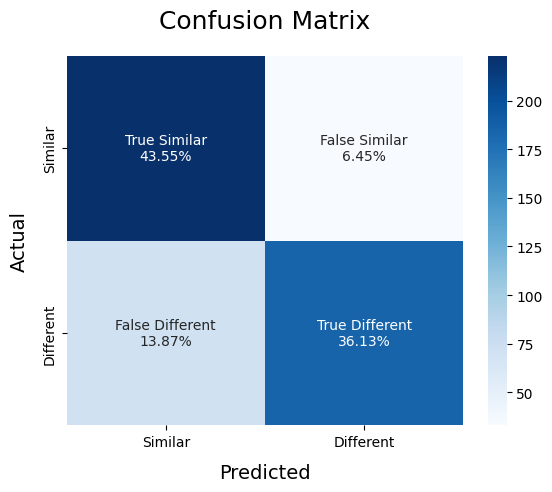

In [73]:

def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

    # Accuracy, Precision, Recall, F1-Score
    print("\nClassification Report:\n")
    print(classification_report(true, pred, target_names=categories))
ModelMetrics(pos_list, neg_list)

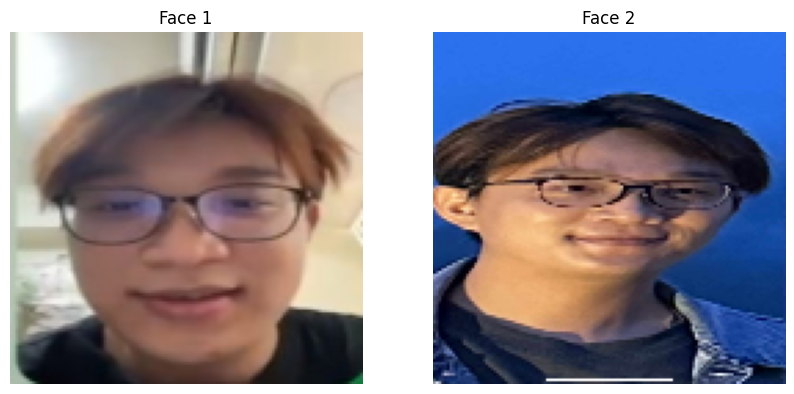

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Different person


In [79]:
# test for 2 images
face_1 = readImage(('bin', '4.jpg'))
face_2 = readImage(('bin', '3.jpg'))


face_1 = cv2.resize(face_1, (128, 128))
face_2 = cv2.resize(face_2, (128, 128))

# show images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(face_1)
plt.title('Face 1')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(face_2)
plt.title('Face 2')
plt.axis('off')
plt.show()

face_1 = preprocess_input(face_1)
face_2 = preprocess_input(face_2)

#
face_1 = tf.convert_to_tensor(np.array([face_1], dtype="float32"))
face_2 = tf.convert_to_tensor(np.array([face_2], dtype="float32"))

prediction = classify_images(face_1, face_2, threshold=1.0)
print('Same person' if prediction[0]==0 else 'Different person')